In [1]:
# Add the root location of the repo to sys.path in order to import modules
import os
print(os.getcwd())

# Change to Fork version of Pulser
import sys
sys.path.append('/Users/julienbremont/Documents/Pulserdev/Pulser')
sys.path

import numpy as np
import matplotlib.pyplot as plt
import qutip
from qutip.measurement import measure_observable
from qutip.metrics import tracedist
import itertools

from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation, SimConfig
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser.devices import Chadoq2

/Users/julienbremont/Documents/Pulserdev


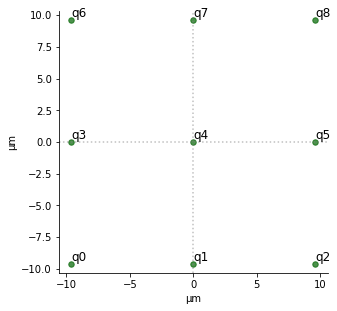

True

In [2]:
# sim parameters
Omega_0 = 0.
Omega_max = 2.3 * 2*np.pi 
U = Omega_max / 2.3

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 2500
t_fall = 5000
t_sweep = (delta_f - delta_0)/(2 * np.pi * 10) * 1000

R_interatomic = Chadoq2.rydberg_blockade_radius(U)
N_side = 3

reg = Register.square(N_side, R_interatomic, prefix='q')
reg.draw()
num_qubits = N_side ** 2
zero_state = qutip.basis(2, 0).proj()
one_state = qutip.basis(2, 1).proj()
hadamard = 1/np.sqrt(2) * qutip.Qobj([[1., 1.], [1., -1.]])
h_mul_phase = qutip.Qobj(np.array([[1., 1], [1.j, -1.j]])) / np.sqrt(2)
unitary_ensemble = [hadamard, h_mul_phase, qutip.qeye(2)]
unitary_ensemble[1].inv() == unitary_ensemble[1].dag()

In [3]:
def prep_pulse_seq(delta):
    """
    Defines a pulse going through the rectangular path in (delta, Omega) space
    and stopping at given delta detuning.
    """
    rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
    sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta), 0.)
    fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta, 0.)
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')

    seq.add(rise, 'ising')
    seq.add(sweep, 'ising')
    seq.add(fall, 'ising')
    return seq

In [4]:
def build_unitary(indices):
    return qutip.tensor([unitary_ensemble[i] for i in indices])

In [5]:
def calculate_classical_shadow(rho, shadow_size):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes as bitstrings
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
    """
    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    # measuring Paulis is equivalent to rotating with Clifford circuits 
    # (Hadamard, Hadamard*PhaseZ, Id) : change of basis to eigenstates of Pauli's
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = []
    for ns in range(shadow_size):
        unitmat = qutip.tensor([unitary_ensemble[unitary_ids[ns, i]] for i in range(num_qubits)])
        probs = np.real((unitmat.dag() * rho * unitmat).diag())
        probs /= np.sum(probs)
        x = np.nonzero(np.random.multinomial(1, probs))[0][0]
        bitstring = np.binary_repr(x, num_qubits)
        outcomes.append(bitstring)

    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

In [6]:
def snapshot_state(outcome_ns, unitary_ids_ns):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        outcome_ns: Bitstring at ns
        unitary_ids_ns: Rotation applied at ns. 

    Returns:
        Reconstructed snapshot.
    """
    state_list = []
    
    for k in range(num_qubits):
        op = unitary_ensemble[unitary_ids_ns[k]]
        b = zero_state if outcome_ns[k] == '0' else one_state
        state_list.append(3 * op * b * op.dag() - qutip.qeye(2))
    
    return qutip.tensor(state_list)

In [7]:
def state_reconstruction(snaps):
    return sum(snaps) / len(snaps)

In [8]:
num_qubits=2
shadow_size = 1000
rho_1 = (qutip.tensor([qutip.basis(2,0), qutip.basis(2,0)]) + qutip.tensor([qutip.basis(2,0), qutip.basis(2,1)])).proj().unit()
rho = (qutip.basis(2,1) + qutip.basis(2,0)).unit().proj()
print("Original density matrix :")
print(rho_1.full())
outcomes, unitary_ids = calculate_classical_shadow(rho_1, shadow_size)
snapshots = [snapshot_state(outcomes[ns], unitary_ids[ns]) for ns in range(shadow_size)]
print("\n Shadow reconstruction :")
print(np.around(state_reconstruction(snapshots).full(), 2))

Original density matrix :
[[0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]

 Shadow reconstruction :
[[ 0.47+0.j    0.49+0.12j  0.01-0.j    0.03+0.04j]
 [ 0.49-0.12j  0.54+0.j    0.  -0.02j  0.02+0.02j]
 [ 0.01+0.j    0.  +0.02j  0.  +0.j    0.01-0.01j]
 [ 0.03-0.04j  0.02-0.02j  0.01+0.01j -0.01+0.j  ]]


In [9]:
num_qubits = 2
dist = np.zeros(5)
for i, shadow_size in enumerate([100, 1000, 2000, 5000, 10000]):
    outcomes, unitary_ids = calculate_classical_shadow(rho_1, shadow_size)
    snapshots = [snapshot_state(outcomes[ns], unitary_ids[ns]) for ns in range(shadow_size)]
    dist[i] = tracedist(state_reconstruction(snapshots), rho_1)

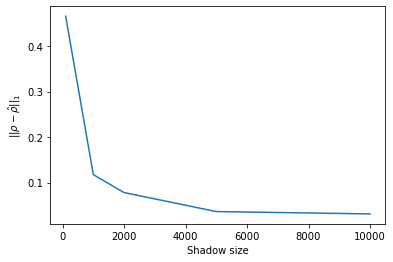

In [10]:
plt.plot([100, 1000, 2000, 5000, 10000], dist)
plt.xlabel("Shadow size")
plt.ylabel(r"$||\rho - \hat{\rho}||_1$")
plt.show()

In [12]:
def _median_of_means(obs, snap_list, K):
    if K > len(snap_list):  # preventing the n_blocks > n_observations
        K = int(np.ceil(len(snap_list) / 2))
    # dividing seq in K random blocks
    indic = np.array((list(range(K)) * int(len(snap_list) / K)))
    np.random.shuffle(indic)
    # computing and saving mean per block
    means = []
    for block in range(K):
        #print(len(np.where(indic==block)[0]))
        states = [snap_list[i] for i in np.where(indic==block)[0]]
        exp = qutip.expect(obs, states)
        means.append(np.mean(exp))
        #print(means[-1])
    return np.median(means)

In [13]:
def compute_shadow_size(delta, epsilon, observables):
    """Helper function.
    
    Computes both the number of shadows needed as well as the size of blocks needed 
    for the median_of_means method in order to approximate the expectation value of M
    (linear) observables with additive error epsilon and fail probability delta.
    
    Args:
        delta (float): Fail probability.
        epsilon (float): Additive error on expectation values.
        observables (list[qutip.Qobj]): Observables the expectation value of which is to 
        be computed."""
    M = len(observables)
    K = 2 * np.log(2 * M / delta)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
            ) ** 2
        )
    #N = 34 * max(shadow_norm(o) for o in observables) / epsilon ** 2
    N = 10
    return int(np.ceil(N * K)), int(K)

In [14]:
def sweep_stagger(sweep_steps):
    observables = [qutip.tensor([qutip.sigmaz() if i == k else qutip.qeye(2) 
                                 for i in range(num_qubits)])
                   for k in range(num_qubits)]
    shadow_size, K = compute_shadow_size(0.1, 0.5, observables)
    results = np.zeros(sweep_steps)
    delta_space = np.linspace(-2*U, 4*U, sweep_steps)
    for i_d, delta in enumerate(delta_space):
        seq = prep_pulse_seq(delta)
        sim = Simulation(seq)
        rho = sim.run().get_final_state().proj()
        outcomes, unitary_ids = calculate_classical_shadow(rho, shadow_size)
        snapshots = [snapshot_state(outcomes[ns], unitary_ids[ns]) for ns in range(shadow_size)]
        meds = [_median_of_means(obs, snapshots, K) for obs in observables]
        stagger = sum([(-1)**k * meds[k] for k in range(num_qubits)]) / num_qubits
        results[i_d] = stagger
    return results, delta_space / U

In [15]:
def sweep_ideal_stagger(sweep_steps):
    observables = [qutip.tensor([qutip.sigmaz() if i == k else qutip.qeye(2) 
                                 for i in range(num_qubits)])
                   for k in range(num_qubits)]
    stag_op = sum([(-1)**k * observables[k] for k in range(num_qubits)]) / num_qubits
    shadow_size, K = compute_shadow_size(0.1, 0.5, observables)
    results = np.zeros(sweep_steps)
    delta_space = np.linspace(-2*U, 4*U, sweep_steps)
    for i_d, delta in enumerate(delta_space):
        seq = prep_pulse_seq(delta)
        sim = Simulation(seq)
        print(sim.run().expect([stag_op])[0][-1])
        results[i_d] = sim.run().expect([stag_op])[0][-1]
    return results, delta_space / U

In [16]:
def sweep_fidelity(sweep_steps):
    proj = qutip.tensor([qutip.basis(2, i % 2) for i in range(num_qubits)]).proj()
    shadow_size, K = compute_shadow_size(0.1, 0.5, [proj])
    results = np.zeros(sweep_steps)
    delta_space = np.linspace(-2*U, 4*U, sweep_steps)
    for i_d, delta in enumerate(delta_space):
        seq = prep_pulse_seq(delta)
        sim = Simulation(seq)
        rho = sim.run().get_final_state().proj()
        outcomes, unitary_ids = calculate_classical_shadow(rho, shadow_size)
        snapshots = [snapshot_state(outcomes[ns], unitary_ids[ns]) for ns in range(shadow_size)]
        med = _median_of_means(proj, snapshots, K)
        results[i_d] = med
    return results, delta_space / U

In [17]:
num_qubits = 9

In [90]:
sweep_results, delta = sweep_stagger(5)

In [92]:
sweep_ideal, delta = sweep_ideal_stagger(5)

-0.11121019885939394
-0.10651658432536479
0.920682964104812
0.5437370788057436
-0.09433848989996448


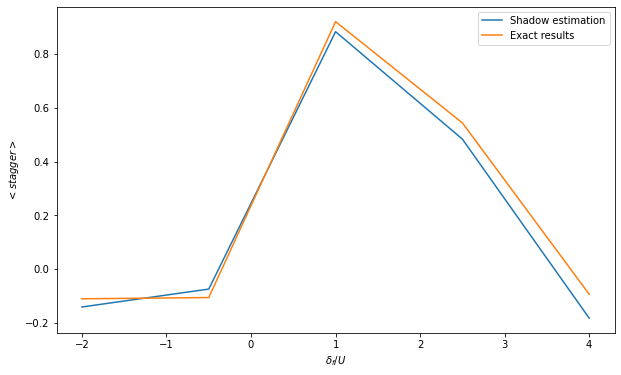

In [93]:
plt.figure(figsize=(10,6))
fig = plt.plot(delta, sweep_results)
plt.plot(delta, sweep_ideal)
plt.legend(["Shadow estimation", "Exact results"])
plt.xlabel(r"$\delta_f / U$")
plt.ylabel(r"$<stagger>$")

plt.show()

In [69]:
def sweep_ideal_fidelity(sweep_steps):
    observables = [qutip.tensor([qutip.basis(2, i % 2) for i in range(num_qubits)]).proj()]
    shadow_size, K = compute_shadow_size(0.1, 0.5, observables)
    results = np.zeros(sweep_steps)
    delta_space = np.linspace(-2*U, 4*U, sweep_steps)
    for i_d, delta in enumerate(delta_space):
        seq = prep_pulse_seq(delta)
        sim = Simulation(seq)
        print(sim.run().expect(observables)[0][-1])
        results[i_d] = sim.run().expect(observables)[0][-1]
    return results, delta_space / U

In [125]:
sweep_fed, delta = sweep_fidelity(7)

In [126]:
sweep_id_fed, delta = sweep_ideal_fidelity(7)

5.310993463321258e-16
3.3669104515187585e-13
0.0012935833160251891
0.9080366496177135
0.8895574552919367
0.0003559056719803517
3.732458862067818e-07


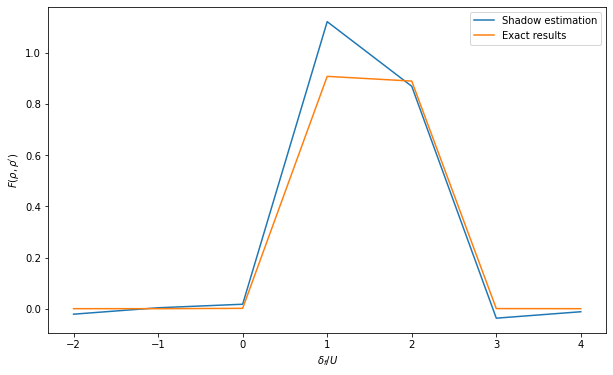

In [127]:
plt.figure(figsize=(10,6))
fig = plt.plot(delta, sweep_fed)
plt.plot(delta, sweep_id_fed)
plt.legend(["Shadow estimation", "Exact results"])
plt.xlabel(r"$\delta_f / U$")
plt.ylabel(r"$F(\rho, \rho')$")
plt.show()

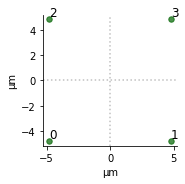

In [34]:
# H2 Molecule : 8 qubits in Bravyi-Kitaev mapping of the Hamiltonian
R_interatomic = Chadoq2.rydberg_blockade_radius(U)
reg = Register.rectangle(2, 2, R_interatomic)
reg.draw()
dur = 500

In [35]:
Pulse.ConstantDetuning(ConstantWaveform(1000, 1), 0, 0)

Pulse(amp=ConstantWaveform(1000 ns, 1 rad/µs), detuning=ConstantWaveform(1000 ns, 0 rad/µs), phase=0, post_phase_shift=0)

In [44]:
# rabi freqs don't need normalization by hbar
# lists of same sizes
def prepare_pauli_pulse(paulis, qids, coef):
    for i, pauli in enumerate(paulis):
        if pauli == "X":
            pulse = Pulse.ConstantDetuning(ConstantWaveform(500, coef), 0, 0)
        if pauli == "Y":
            pulse = Pulse.ConstantDetuning(ConstantWaveform(500, coef), 0., np.pi / 2)
        if pauli == "Z":
            pulse = Pulse.ConstantAmplitude(0, ConstantWaveform(500, coef), 0)
        seq.target(qids[i], "ram")
        seq.add(pulse, "ram")

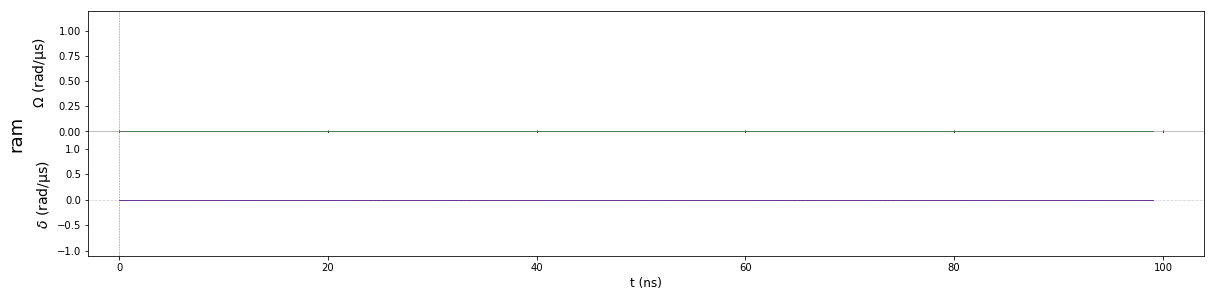

In [45]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ram", "raman_local")
seq.draw()

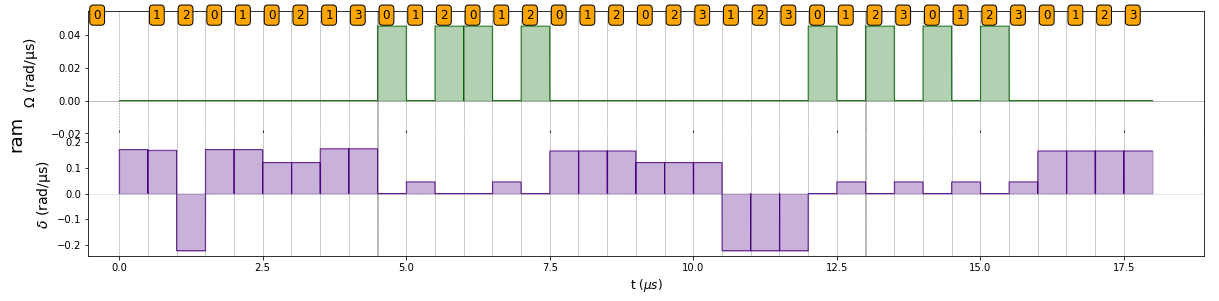

In [38]:
prepare_pauli_pulse(["Z"], [0], 0.1712)
prepare_pauli_pulse(["Z"], [1], 0.1686)
prepare_pauli_pulse(["Z"], [2], -0.2227)
prepare_pauli_pulse(["Z", "Z"], [0,1], 0.1712)
prepare_pauli_pulse(["Z", "Z"], [0,2], 0.1205)
prepare_pauli_pulse(["Z", "Z"], [1,3], 0.1743)
prepare_pauli_pulse(["X", "Z", "X"], [0,1,2], 0.0453)
prepare_pauli_pulse(["Y", "Z", "Y"], [0,1,2], 0.0453)
prepare_pauli_pulse(["Z", "Z", "Z"], [0, 1, 2], 0.1658)
prepare_pauli_pulse(["Z", "Z", "Z"], [0,2,3], 0.1205)
prepare_pauli_pulse(["Z", "Z", "Z"], [1,2,3], -0.2227)
prepare_pauli_pulse(["X", "Z", "X", "Z"], [0,1,2,3], 0.0453)
prepare_pauli_pulse(["Y","Z","Y","Z"], [0,1,2,3], 0.0453)
prepare_pauli_pulse(["Z","Z","Z","Z"], [0,1,2,3], 0.1658)
seq.draw()

In [39]:
sigmas = [qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]
def pau(pids, qids):
    tensorlist = []
    j = 0
    for i in range(4):
        if i in qids:
            tensorlist.append(sigmas[pids[j]])
            j += 1
        else:
            tensorlist.append(qutip.qeye(2))
    return qutip.tensor(tensorlist)

In [40]:
ham = (-0.81261 * pau([], []) + 0.171201 * pau([2], [0]) +  0.16862325 * pau([2], [1]) - 0.2227965 * pau([2], [2]) + 
    0.171201 * pau([2,2], [0,1]) + 0.12054625 * pau([2,2], [0,2]) + 0.17434925 * pau([2,2], [1,3]) +
       0.04532175 * pau([0,2,0], [0,1,2]) + 0.04532175 * pau([1,2,1], [0,1,2]) + 0.165868 * pau([2,2,2], [0,1,2]) +
       0.12054625 * pau([2,2,2], [0,2,3]) - 0.2227965 * pau([2,2,2], [1,2,3]) +  0.04532175 * pau([0,2,0,2], [0,1,2,3]) +
       0.04532175 * pau([1,2,1,2], [0,1,2,3]) + 0.165868 * pau([2,2,2,2], [0,1,2,3])
      )

In [43]:
ground = qutip.tensor([qutip.basis(2,1) for _ in range(4)])
f_state = qutip.sesolve(ham, ground, tlist = np.linspace(0, 100, 1000)).states

[ 0.          0.          0.         ... -0.00175664 -0.00175664
 -0.00175664]


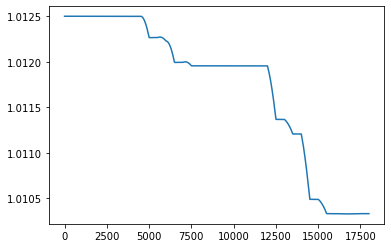

In [229]:
sim = Simulation(seq)
plt.plot(sim.run().expect([ham])[0])

In [159]:
def hits(p, o, end=-1):
    """Determines if measurement p hits observable o
    Args:
        p (str): Pauli string in str format (ex "1XYZ"), measurement
        o (str): same as above, observable
        start (int): index after which to check if p hits o
    """
    if end != -1:
        o = o[:end]
    for i, x in enumerate(o):
        if not(x == p[i] or x == "1"):
            return False
    return True

In [79]:
def weight(o, start=0):
    o_k = o[start:]
    return len(o_k) - o_k.count("1")

In [168]:
weight("XY11", start=2)

0

In [87]:
"abc"[:3]

'abc'

In [104]:
2**4

16

In [221]:
def cond_conf(epsilon, M, o, P_sharp):
    """Returns the conditionned expectation value of the cost function depending
    on already chosen Paulis in P_sharp
    
    Args:
        epsilon (float): desired accuracy on observable expectation values
        M (int): measurement budget, so number of measurements as Pauli strings
        o (list[str]): list of Pauli strings to be measured
        P_sharp (list[str]): list of already chosen Paulis
    """
    nu = 1 - np.exp(-epsilon**2 / 2)
    L = len(o)
    m = len(P_sharp) - 1 # index of last chosen Pauli string
    k = len(P_sharp[-1]) - 1 # index of last chosen Pauli matrix in mth Pauli string
    result = 0
    for l in range(0, L):
        cache = np.exp((-epsilon**2 / 2) * sum([int(hits(P_sharp[m_prime], o[l])) for m_prime in range(m)]))
        cache *= (1 - nu * 3**(-weight(o[l], start=k+1)) * int(hits(P_sharp[m], o[l], end=k+1)))
        cache *= (1 - nu * 3**(-weight(o[l])))**(M-m)
        result += cache
    return result

In [227]:
o = ["XZ", "YZ"]
P_sharp = ["XZ"]
cond_conf(1, 10, o, P_sharp)

1.0274131640590944

In [236]:
def derandomization(M, epsilon, o):
    """Derandomization algorithm returning best Pauli indices according to a gluttonous algorithm
    that aims at minimizing the cost function above.
    
    Args:
        M (int): number of measurements
        n (int): number of qubits (size of Pauli strings)
        epsilon (float): desired accuracy on observable expectation values
        o (list[str]): list of Pauli strings to be measured
    """
    n = len(o[0])
    P_sharp = []
    for m in range(M):
        P_sharp.append("")
        for k in range(n):
            P_sharp_m = P_sharp[m]
            P_sharp[m] += "X"
            valmin = cond_conf(epsilon, M, o, P_sharp)
            argmin = "X"
            for W in ["Y", "Z"]:
                P_sharp[m] = P_sharp_m + W
                val_W = cond_conf(epsilon, M, o, P_sharp)
                if val_W < valmin:
                    valmin = val_W
                    argmin = W
            P_sharp[m] = P_sharp_m + argmin
    return P_sharp

In [247]:
derandomization(2, 1, ["Z11", "11Z"])

['ZXZ', 'ZXZ']